In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle
from pathlib import Path
from importlib import reload
from IPython.display import clear_output

from roman_cgi_iefc import cgi
from roman_cgi_iefc import iefc_utils as iefcu
from roman_cgi_iefc import iefc_sim_2dm as iefc2

import misc

import proper
proper.prop_use_fftw(DISABLE=False)
# proper.prop_fftw_wisdom( 1024 ) 

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

dm1_flatmap = fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')

# Initialize mode

In [2]:
reload(cgi)

hlci = cgi.CGI_PROPER(use_opds=False, use_fieldstop=False, quiet=True)
npsf = hlci.npsf
Nact = hlci.Nact

# Create dark hole ROI to calibrate and control

(4096,) (4096,) (4096,) (4096,)


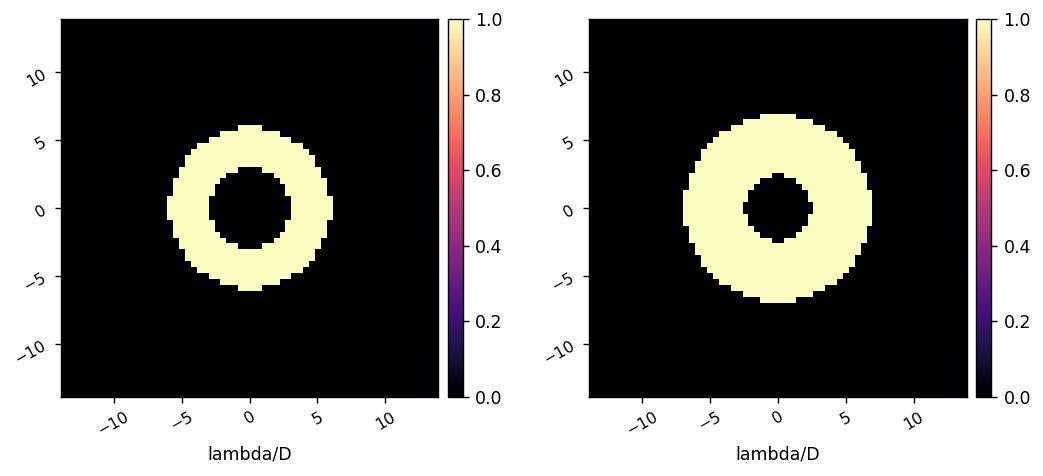

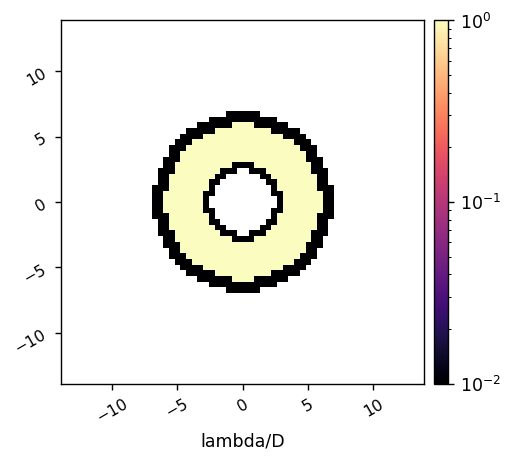

In [3]:
reload(iefcu)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * hlci.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 2
iwa = 3
owa = 6

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : ''
}
dh_mask = iefcu.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.5,
    'outer_radius' : owa+1,
    'edge_position' : edge,
    'direction' : ''
}
control_mask = iefcu.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.99
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

print(dh_mask.shape, control_mask.shape, control_mask.shape, weights.shape)
misc.myimshow2(dh_mask.reshape(npsf,npsf), control_mask.reshape(npsf,npsf), 
               pxscl1=hlci.psf_pixelscale_lamD, pxscl2=hlci.psf_pixelscale_lamD)
misc.myimshow(weights.reshape(npsf,npsf), lognorm=True, pxscl=hlci.psf_pixelscale_lamD)

# Create probe and fourier modes

Creating Fourier modes:  (64, 64)
Calibration modes required: 296


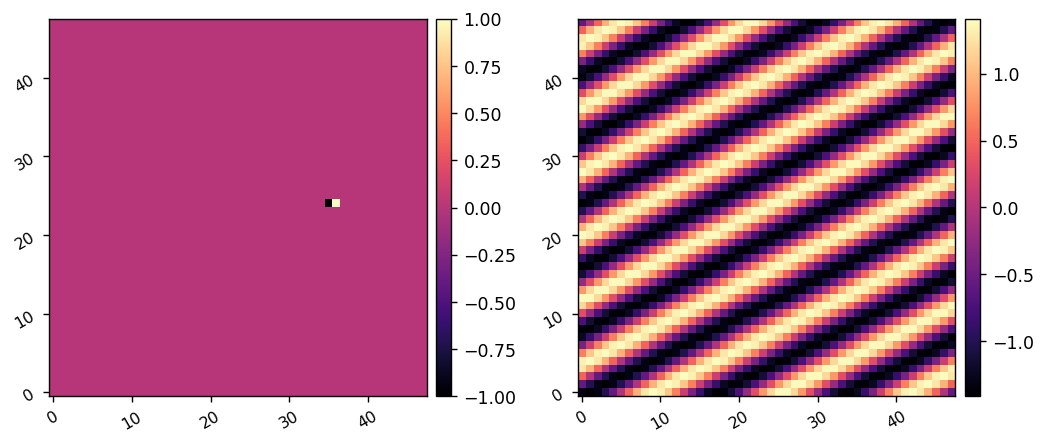

In [4]:
reload(iefc2)

fourier_modes, fx, fy = iefcu.create_fourier_modes(xfp, control_mask.reshape((npsf,npsf)), Nact, circular_mask=False)
probe_modes = iefcu.create_probe_poke_modes(Nact, 3*Nact//4, Nact//2, 3*Nact//4-1, Nact//2)

calibration_amplitude = 0.006 * hlci.wavelength.to(u.m).value
probe_amplitude = 0.05 * hlci.wavelength.to(u.m).value
nmodes = fourier_modes.shape[0]

print('Calibration modes required: {:d}'.format(nmodes))
calibration_mode = fourier_modes[10]
misc.myimshow2((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)), calibration_mode.reshape(Nact,Nact))

# Create control matrix

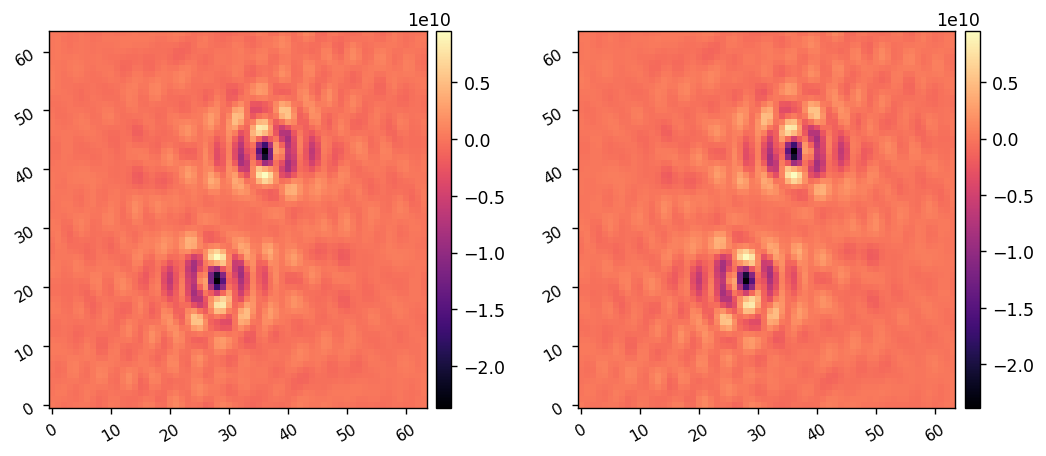

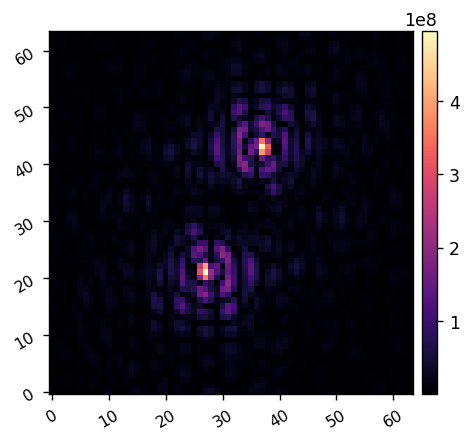

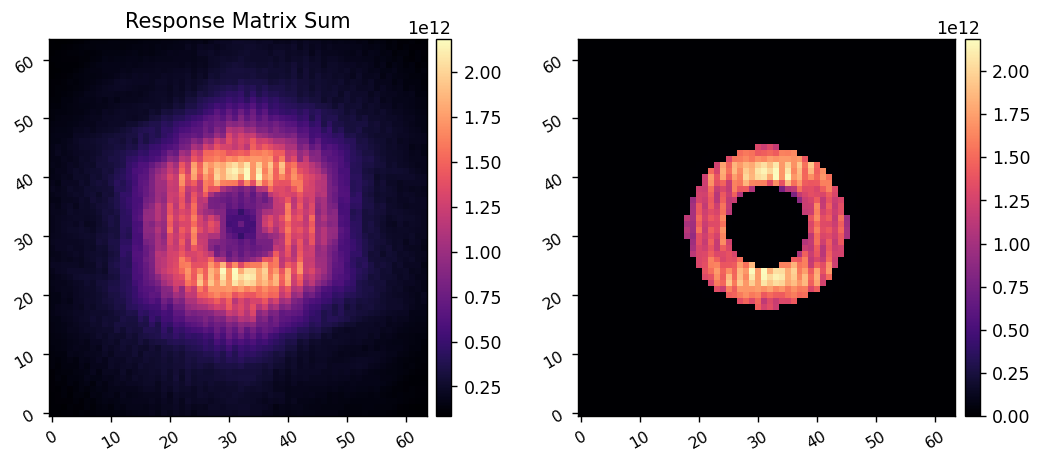

(592, 2, 4096)


In [5]:
response_cube = fits.getdata(data_dir/'response-data'/'hlc_response_cube_annular_3to6_v3.fits')
misc.myimshow2(response_cube[15,0].reshape(npsf,npsf), response_cube[15+nmodes,0].reshape(npsf,npsf))

misc.myimshow( abs(response_cube[15,0] - response_cube[15+nmodes,0]).reshape(npsf,npsf) )

sum_responses = np.sum(abs(response_cube[:,:,:npsf**2]), axis=(0,1))
misc.myimshow2(sum_responses.reshape(64,64), (weights*sum_responses).reshape(64,64), 'Response Matrix Sum')

print(response_cube.shape)

In [6]:
reload(iefc2)
# OPTIONAL: Filter the calibration files by subtracting PCA modes
# npca = 3
# filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)
rcond1 = 0.01
rcond2 = 0.01
control_matrix_1 = iefc2.construct_control_matrix(response_cube, weights, rcond1=rcond1, rcond2=rcond2, WLS=True,) 
control_matrix_2 = iefc2.construct_control_matrix(response_cube, weights, rcond1=rcond1, rcond2=rcond2, WLS=False,) 

print(control_matrix_1.shape, control_matrix_2.shape, control_mask.sum()*2)

Using Weighted Least Squares 
Using Tikhonov Inverse
(592, 1384) (592, 1384) 1384


# Run IEFC

Closed-loop iteration 1 / 10


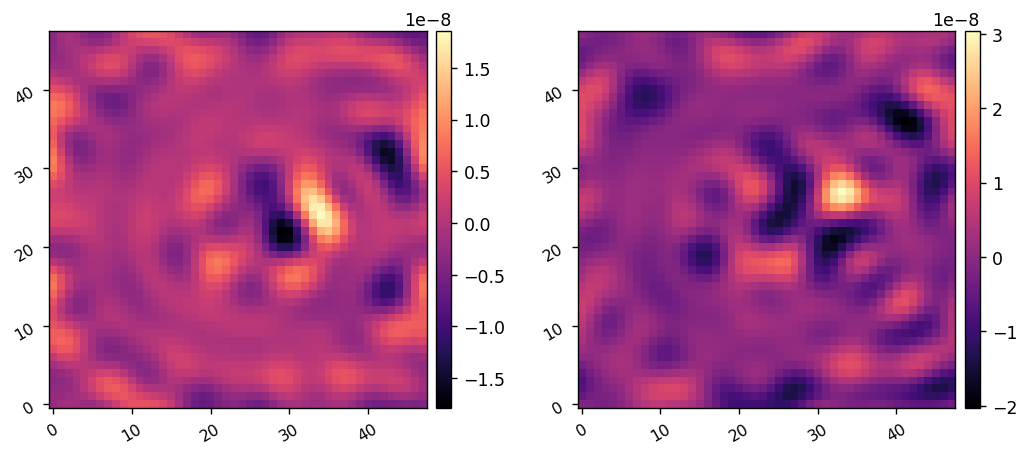

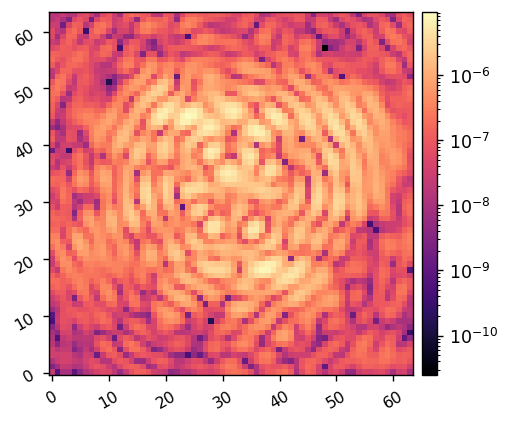

Closed-loop iteration 2 / 10


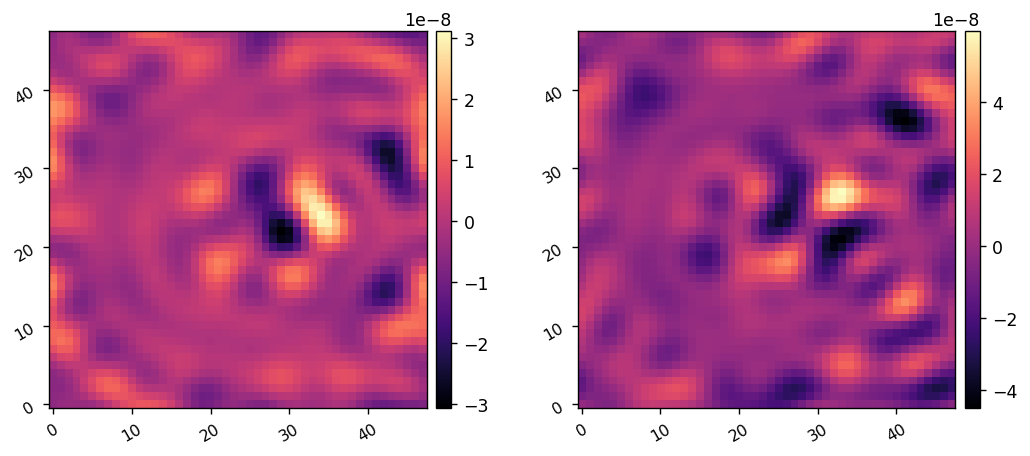

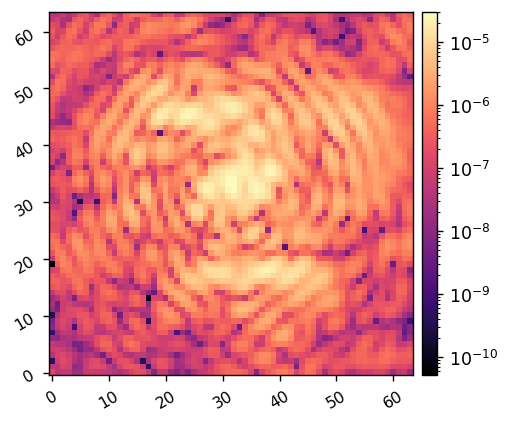

Closed-loop iteration 3 / 10


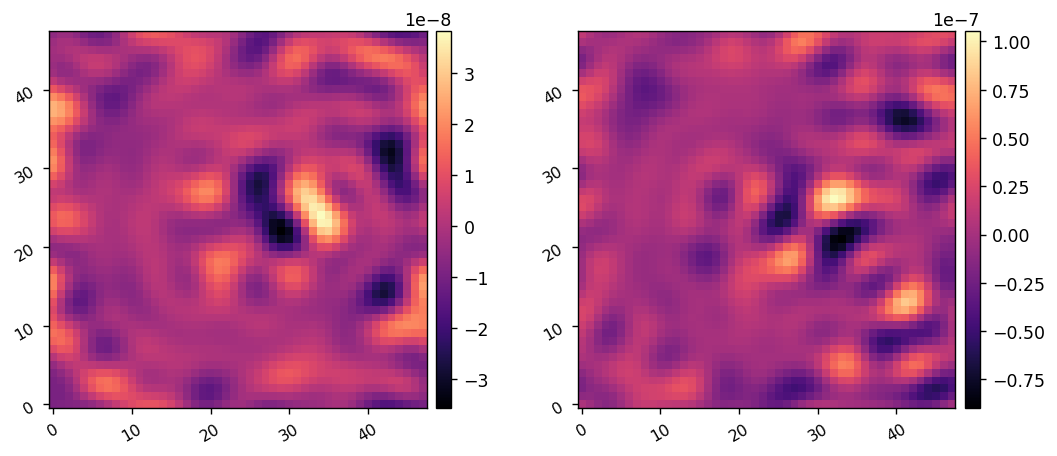

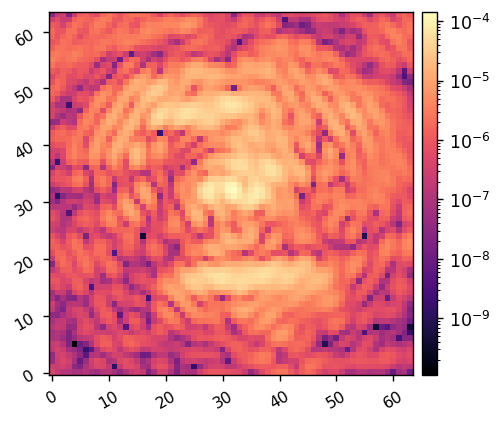

Closed-loop iteration 4 / 10


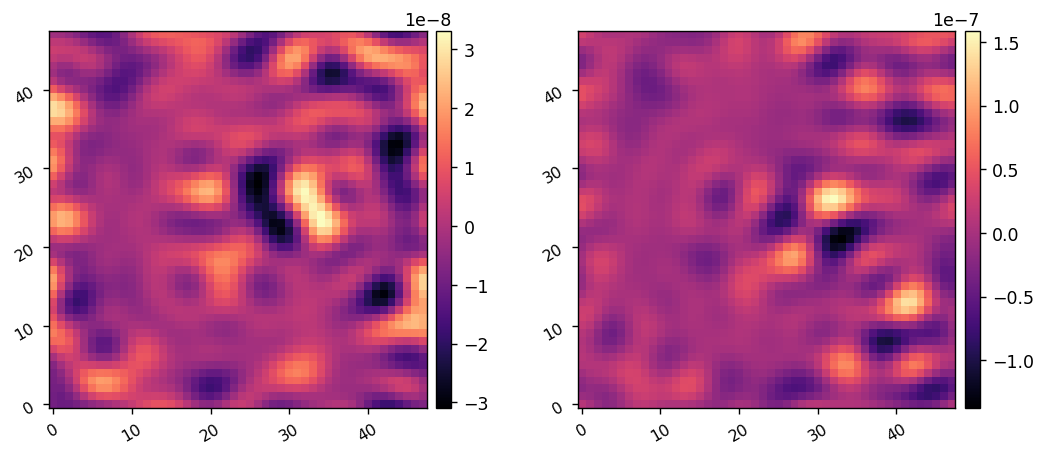

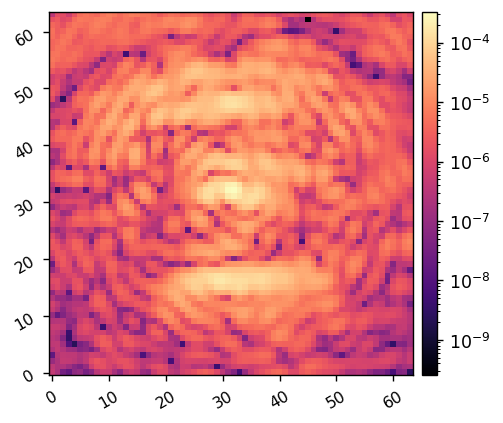

Closed-loop iteration 5 / 10


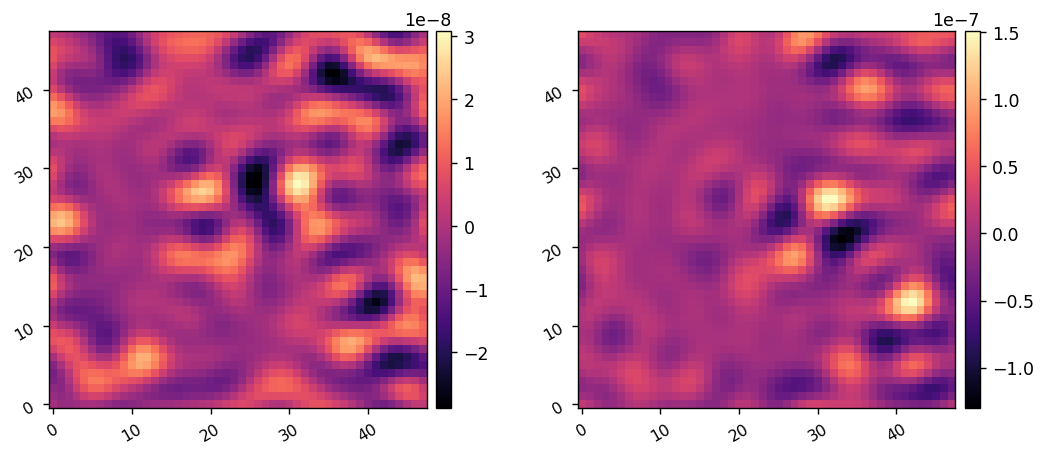

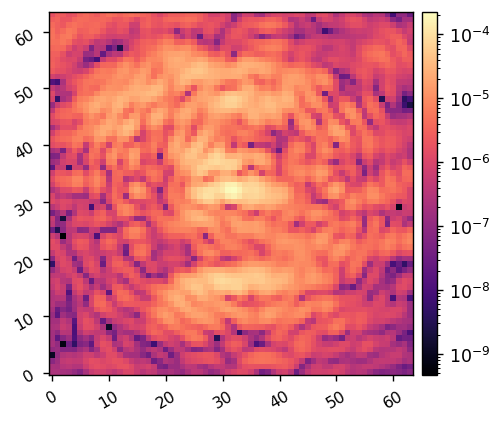

Closed-loop iteration 6 / 10


In [ ]:
reload(iefc2)

metric_images = []
dm1_commands = []
dm2_commands = []
commands = 0.0

## Run IEFC for num_iterations
num_iterations = 10
gain = -0.5
leakage = 0.0

for i in range(num_iterations):
    print("Closed-loop iteration {:d} / {:d}".format(i+1, num_iterations))
    delta_coefficients = iefc2.single_iteration(hlci, probe_modes, probe_amplitude, control_matrix_2, weights.flatten()>0)
    commands = (1.0-leakage) * commands + gain * delta_coefficients
    
    # Reconstruct the full phase from the Fourier modes
#     dm_commands = np.einsum('ij, i->j', np.concatenate((fourier_modes,fourier_modes),axis=1), command)
#     dm_commands = np.concatenate((fourier_modes,fourier_modes),axis=1).T.dot(command)
    dm1 = fourier_modes.T.dot(commands[:nmodes])
    dm2 = fourier_modes.T.dot(commands[nmodes:])
    
#     break
    
    # Set the current DM state
    hlci.set_dm1(dm1)
    hlci.set_dm2(dm2)
    
    # Take an image to estimate the metrics
    image = hlci.calc_psf()
    metric_images.append(image)
    dm1_commands.append(hlci.DM1)
    dm2_commands.append(hlci.DM2)
    
    misc.myimshow2(hlci.DM1, hlci.DM2)
    misc.myimshow(image, lognorm=True)
    pass

In [17]:
fourier_modes.shape, commands.shape

((296, 2304), (592,))